In [1]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query = """
SELECT 
    pe.[PitcherId],
	pl.NamePlayer,
    pe.[PitHand],
     p.[x0]
      ,p.[y0]
      ,p.[z0]
      ,p.[vx0]
      ,p.[vy0]
      ,p.[vz0]
      ,p.[ax]
      ,p.[ay]
      ,p.[az],
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px
FROM 
    [mlb_stats].[dbo].[pbp_play_event] pe
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_play_event_pitch] p 
    ON p.[GamePk] = pe.[GamePk] 
    AND p.[PlayId] = pe.[PlayId] 
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_game] g
    ON g.[GamePk] = pe.[GamePk]
LEFT JOIN 
    [mlb_stats].[dbo].[mlb_roster_status] pl
    ON pl.[PlayerID] = pe.[PitcherId] 
WHERE 
    pe.[IsPitch] = 1  
    AND p.PitchType = 'FA' 
    AND YEAR(g.GameDate) = 2024
    AND g.LeagueLevel = 1
	AND g.GameType = 'R'
"""

fastballs=pd.read_sql(query,cnxn) 



C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\2712904159.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fastballs=pd.read_sql(query,cnxn)


In [53]:
def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA

In [56]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_si = """
SELECT 
    pe.[PitcherId],
	pl.NamePlayer,
    pe.[PitHand],
     p.[x0]
      ,p.[y0]
      ,p.[z0]
      ,p.[vx0]
      ,p.[vy0]
      ,p.[vz0]
      ,p.[ax]
      ,p.[ay]
      ,p.[az],
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px
FROM 
    [mlb_stats].[dbo].[pbp_play_event] pe
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_play_event_pitch] p 
    ON p.[GamePk] = pe.[GamePk] 
    AND p.[PlayId] = pe.[PlayId] 
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_game] g
    ON g.[GamePk] = pe.[GamePk]
LEFT JOIN 
    [mlb_stats].[dbo].[mlb_roster_status] pl
    ON pl.[PlayerID] = pe.[PitcherId] 
WHERE 
    pe.[IsPitch] = 1  
    AND p.PitchType = 'SI' 
    AND YEAR(g.GameDate) = 2024
    AND g.LeagueLevel = 1
	AND g.GameType = 'R'
"""

sinkers=pd.read_sql(query_si,cnxn) 


filtered_si = sinkers.loc[:, [
    'PitcherId',
    'NamePlayer',
    'PitHand',
    'x0',
    'y0',
    'z0',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'PitchType',
    'StartSpeed',
    'SpinRate',
    'Extension',
    'ReleaseX',
    'ReleaseZ',
    'ReleaseAngle',
    'ReleaseDirection',
    'pz',
    'px'
]]
filtered_si['VRA'] = filtered_si.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
filtered_si['HRA'] = filtered_si.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)
pitch_count = filtered_si['NamePlayer'].value_counts()

filtered_si_filtered = filtered_si[filtered_si['NamePlayer'].isin(pitch_count.index[pitch_count >= 100])]
grouped_si = filtered_si_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
   # 'NamePlayer': 'first',  
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
 #   'type': lambda x: (x == 'S').sum() / len(x)   Calculate strike rate for each pitcher
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_si['VRA_percentile'] = 1 - grouped_si['VRA'].rank(pct=True)
grouped_si['HRA_percentile'] = 1 - grouped_si['HRA'].rank(pct=True)
grouped_si['release_pos_z_percentile'] = 1 - grouped_si['ReleaseZ'].rank(pct=True)
grouped_si['release_pos_x_percentile'] = 1 - grouped_si['ReleaseX'].rank(pct=True)

grouped_si['kirby_index'] = (
    grouped_si['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_si['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_si['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_si['release_pos_x_percentile'] * weights['ReleaseX']
)

ranked_pitchers_weighted_si = grouped_si.sort_values('kirby_index', ascending=False)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\1246889799.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sinkers=pd.read_sql(query_si,cnxn)


In [2]:
import pandas as pd
import numpy as np
import pybaseball as pyb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, atan2, degrees, pi
from scipy.stats import percentileofscore
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_rows', None)

In [4]:
filtered_ff = fastballs.loc[:, [
    'PitcherId',
    'NamePlayer',
    'PitHand',
    'x0',
    'y0',
    'z0',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'PitchType',
    'StartSpeed',
    'SpinRate',
    'Extension',
    'ReleaseX',
    'ReleaseZ',
    'ReleaseAngle',
    'ReleaseDirection',
    'pz',
    'px'
]]

In [5]:
filtered_ff['VRA'] = filtered_ff.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
filtered_ff['HRA'] = filtered_ff.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)

In [6]:
pitch_count = filtered_ff['NamePlayer'].value_counts()

filtered_ff_filtered = filtered_ff[filtered_ff['NamePlayer'].isin(pitch_count.index[pitch_count >= 200])]

In [7]:
grouped_ff = filtered_ff_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
}).reset_index()  

weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_ff['VRA_percentile'] = 1 - grouped_ff['VRA'].rank(pct=True)
grouped_ff['HRA_percentile'] = 1 - grouped_ff['HRA'].rank(pct=True)
grouped_ff['release_pos_z_percentile'] = 1 - grouped_ff['ReleaseZ'].rank(pct=True)
grouped_ff['release_pos_x_percentile'] = 1 - grouped_ff['ReleaseX'].rank(pct=True)

grouped_ff['kirby_index'] = (
    grouped_ff['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_ff['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_ff['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_ff['release_pos_x_percentile'] * weights['ReleaseX']
)

ranked_pitchers_weighted_ff = grouped_ff.sort_values('kirby_index', ascending=False)

In [8]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complfb = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2024 AND PitchType = 'FA' AND SplitType = 'All' AND Level = 'MLB'
"""

Fastball_Command=pd.read_sql(query_complfb,cnxn) 

print(Fastball_Command)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\2297931262.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Fastball_Command=pd.read_sql(query_complfb,cnxn)


                         Name  PlayerID Throws Level  LeagueLevel  Season  \
0           Verlander, Justin    434378      R   MLB            1    2024   
1             Morton, Charlie    450203      R   MLB            1    2024   
2               Scherzer, Max    453286      R   MLB            1    2024   
3               Martin, Chris    455119      R   MLB            1    2024   
4              Wilson, Justin    458677      L   MLB            1    2024   
5                 Lynn, Lance    458681      R   MLB            1    2024   
6            Carrasco, Carlos    471911      R   MLB            1    2024   
7                García, Luis    472610      R   MLB            1    2024   
8            Kershaw, Clayton    477132      L   MLB            1    2024   
9                 Miley, Wade    489119      L   MLB            1    2024   
10               Yates, Kirby    489446      R   MLB            1    2024   
11             Ottavino, Adam    493603      R   MLB            1    2024   

In [9]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_sl = """
SELECT 
    pe.[PitcherId],
	pl.NamePlayer,
    pe.[PitHand],
     p.[x0]
      ,p.[y0]
      ,p.[z0]
      ,p.[vx0]
      ,p.[vy0]
      ,p.[vz0]
      ,p.[ax]
      ,p.[ay]
      ,p.[az],
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px
FROM 
    [mlb_stats].[dbo].[pbp_play_event] pe
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_play_event_pitch] p 
    ON p.[GamePk] = pe.[GamePk] 
    AND p.[PlayId] = pe.[PlayId] 
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_game] g
    ON g.[GamePk] = pe.[GamePk]
LEFT JOIN 
    [mlb_stats].[dbo].[mlb_roster_status] pl
    ON pl.[PlayerID] = pe.[PitcherId] 
WHERE 
    pe.[IsPitch] = 1  
    AND p.PitchType = 'SL' 
    AND YEAR(g.GameDate) = 2024
    AND g.LeagueLevel = 1
	AND g.GameType = 'R'
"""

sliders=pd.read_sql(query_sl,cnxn) 


filtered_sl = sliders.loc[:, [
    'PitcherId',
    'NamePlayer',
    'PitHand',
    'x0',
    'y0',
    'z0',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'PitchType',
    'StartSpeed',
    'SpinRate',
    'Extension',
    'ReleaseX',
    'ReleaseZ',
    'ReleaseAngle',
    'ReleaseDirection',
    'pz',
    'px'
]]
filtered_sl['VRA'] = filtered_sl.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
filtered_sl['HRA'] = filtered_sl.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)
pitch_count = filtered_sl['NamePlayer'].value_counts()

filtered_sl_filtered = filtered_sl[filtered_sl['NamePlayer'].isin(pitch_count.index[pitch_count >= 100])]
grouped_sl = filtered_sl_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
   # 'NamePlayer': 'first',  
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
 #   'type': lambda x: (x == 'S').sum() / len(x)   Calculate strike rate for each pitcher
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_sl['VRA_percentile'] = 1 - grouped_sl['VRA'].rank(pct=True)
grouped_sl['HRA_percentile'] = 1 - grouped_sl['HRA'].rank(pct=True)
grouped_sl['release_pos_z_percentile'] = 1 - grouped_sl['ReleaseZ'].rank(pct=True)
grouped_sl['release_pos_x_percentile'] = 1 - grouped_sl['ReleaseX'].rank(pct=True)

grouped_sl['kirby_index'] = (
    grouped_sl['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_sl['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_sl['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_sl['release_pos_x_percentile'] * weights['ReleaseX']
)

ranked_pitchers_weighted_sl = grouped_sl.sort_values('kirby_index', ascending=False)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\1732237336.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sliders=pd.read_sql(query_sl,cnxn)


In [33]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_sw = """
SELECT 
    pe.[PitcherId],
	pl.NamePlayer,
    pe.[PitHand],
     p.[x0]
      ,p.[y0]
      ,p.[z0]
      ,p.[vx0]
      ,p.[vy0]
      ,p.[vz0]
      ,p.[ax]
      ,p.[ay]
      ,p.[az],
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px
FROM 
    [mlb_stats].[dbo].[pbp_play_event] pe
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_play_event_pitch] p 
    ON p.[GamePk] = pe.[GamePk] 
    AND p.[PlayId] = pe.[PlayId] 
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_game] g
    ON g.[GamePk] = pe.[GamePk]
LEFT JOIN 
    [mlb_stats].[dbo].[mlb_roster_status] pl
    ON pl.[PlayerID] = pe.[PitcherId] 
WHERE 
    pe.[IsPitch] = 1  
    AND p.PitchType = 'SW' 
    AND YEAR(g.GameDate) = 2024
    AND g.LeagueLevel = 1
	AND g.GameType = 'R'
"""

sweepers=pd.read_sql(query_sw,cnxn) 


filtered_sw = sweepers.loc[:, [
    'PitcherId',
    'NamePlayer',
    'PitHand',
    'x0',
    'y0',
    'z0',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'PitchType',
    'StartSpeed',
    'SpinRate',
    'Extension',
    'ReleaseX',
    'ReleaseZ',
    'ReleaseAngle',
    'ReleaseDirection',
    'pz',
    'px'
]]
filtered_sw['VRA'] = filtered_sw.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
filtered_sw['HRA'] = filtered_sw.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)
pitch_count = filtered_sw['NamePlayer'].value_counts()

filtered_sw_filtered = filtered_sw[filtered_sw['NamePlayer'].isin(pitch_count.index[pitch_count >= 100])]
grouped_sw = filtered_sw_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
   # 'NamePlayer': 'first',  
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
 #   'type': lambda x: (x == 'S').sum() / len(x)   Calculate strike rate for each pitcher
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_sw['VRA_percentile'] = 1 - grouped_sw['VRA'].rank(pct=True)
grouped_sw['HRA_percentile'] = 1 - grouped_sw['HRA'].rank(pct=True)
grouped_sw['release_pos_z_percentile'] = 1 - grouped_sw['ReleaseZ'].rank(pct=True)
grouped_sw['release_pos_x_percentile'] = 1 - grouped_sw['ReleaseX'].rank(pct=True)

grouped_sw['kirby_index'] = (
    grouped_sw['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_sw['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_sw['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_sw['release_pos_x_percentile'] * weights['ReleaseX']
)

ranked_pitchers_weighted_sw = grouped_sw.sort_values('kirby_index', ascending=False)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\4048036007.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sweepers=pd.read_sql(query_sw,cnxn)


In [10]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complfb = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2024 AND PitchType = 'SL' AND SplitType = 'All' AND Level = 'MLB'
"""

Slider_Command=pd.read_sql(query_complfb,cnxn) 

print(Slider_Command)

                         Name  PlayerID Throws Level  LeagueLevel  Season  \
0           Verlander, Justin    434378      R   MLB            1    2024   
1              Jansen, Kenley    445276      R   MLB            1    2024   
2               Chavez, Jesse    445926      R   MLB            1    2024   
3             Morton, Charlie    450203      R   MLB            1    2024   
4               Scherzer, Max    453286      R   MLB            1    2024   
5               Martin, Chris    455119      R   MLB            1    2024   
6              Wilson, Justin    458677      L   MLB            1    2024   
7                 Lynn, Lance    458681      R   MLB            1    2024   
8            Carrasco, Carlos    471911      R   MLB            1    2024   
9                García, Luis    472610      R   MLB            1    2024   
10           Kershaw, Clayton    477132      L   MLB            1    2024   
11               Yates, Kirby    489446      R   MLB            1    2024   

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\2797300711.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Slider_Command=pd.read_sql(query_complfb,cnxn)


In [35]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complfb = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2024 AND PitchType = 'SW' AND SplitType = 'All' AND Level = 'MLB'
"""

SW_Command=pd.read_sql(query_complfb,cnxn) 

print(SW_Command)

                      Name  PlayerID Throws Level  LeagueLevel  Season  \
0            Martin, Chris    455119      R   MLB            1    2024   
1              Lynn, Lance    458681      R   MLB            1    2024   
2         Carrasco, Carlos    471911      R   MLB            1    2024   
3             García, Luis    472610      R   MLB            1    2024   
4              Miley, Wade    489119      L   MLB            1    2024   
5           Ottavino, Adam    493603      R   MLB            1    2024   
6             Gibson, Kyle    502043      R   MLB            1    2024   
7         Robertson, David    502085      R   MLB            1    2024   
8            Espino, Paolo    502179      R   MLB            1    2024   
9          Anderson, Chase    502624      R   MLB            1    2024   
10             Darvish, Yu    506433      R   MLB            1    2024   
11           Diekman, Jake    518617      L   MLB            1    2024   
12          Kimbrel, Craig    518886  

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\853212434.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  SW_Command=pd.read_sql(query_complfb,cnxn)


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde


# Ensure no missing values in the HRA columns of both datasets
filtered_ff_filtered_HRA = filtered_ff_filtered.dropna(subset=['HRA'])
filtered_sl_filtered_HRA = filtered_sl_filtered.dropna(subset=['HRA'])

# Function to calculate the percentage overlap between two distributions
def calculate_overlap(hra_ff, hra_sl):
    kde_ff = gaussian_kde(hra_ff, bw_method='scott')
    kde_sl = gaussian_kde(hra_sl, bw_method='scott')

    x_min = min(hra_ff.min(), hra_sl.min())
    x_max = max(hra_ff.max(), hra_sl.max())
    x_values = np.linspace(x_min, x_max, 1000)

    pdf_ff = kde_ff(x_values)
    pdf_sl = kde_sl(x_values)

    overlap = np.minimum(pdf_ff, pdf_sl)
    overlap_area = np.trapz(overlap, x_values)

    total_area_ff = np.trapz(pdf_ff, x_values)
    total_area_sl = np.trapz(pdf_sl, x_values)
    percentage_overlap = (overlap_area / min(total_area_ff, total_area_sl)) * 100

    return percentage_overlap

# Get unique players
unique_pitchers = set(filtered_ff_filtered_HRA['NamePlayer']).intersection(filtered_sl_filtered_HRA['NamePlayer'])

# Calculate overlap for each player
overlap_results = []

for player in unique_pitchers:
    player_ff = filtered_ff_filtered_HRA[filtered_ff_filtered_HRA['NamePlayer'] == player]
    player_sl = filtered_sl_filtered_HRA[filtered_sl_filtered_HRA['NamePlayer'] == player]
    
    if len(player_ff) > 0 and len(player_sl) > 0:
        overlap_percentage = calculate_overlap(player_ff['HRA'], player_sl['HRA'])
        overlap_results.append({
            'NamePlayer': player,
            'PitcherId': player_ff.iloc[0]['PitcherId'],
            'overlap_percentage': overlap_percentage
        })

# Create a DataFrame with the results
overlap_df = pd.DataFrame(overlap_results)

# Order the results from highest to lowest overlap percentage
league_overlap_df_sorted = overlap_df.sort_values(by='overlap_percentage', ascending=False)

# Display the sorted results
print(league_overlap_df_sorted)


                  NamePlayer  PitcherId  overlap_percentage
145           MacKenzie Gore     669022           96.327522
6         Matthew Liberatore     669461           95.745621
119             Tyler Kinley     641755           95.644179
108             José Leclerc     600917           95.169027
38              Bryce Miller     682243           95.042368
167              Bryce Elder     693821           94.514272
127            Justin Wilson     458677           94.312616
111              Dylan Cease     656302           94.156854
155            Michael Wacha     608379           93.750567
132             Hunter Brown     686613           93.635008
58              Tanner Banks     621383           93.132789
60             Victor Vodnik     680767           92.972369
139              Ryne Stanek     592773           92.947952
78          Triston McKenzie     663474           92.941274
37              Grant Holmes     656550           92.856242
141          Griffin Canning     656288 

In [12]:
selected_sl_stats= Slider_Command.loc[:, ['PlayerID', 'StrikeRate', 'CalledStrikeRate', 'Whiff', 'InZone', 'SwingRate', 'OutZoneSwing','InZoneWhiff', 'StuffPlus']]
full_league_sl_stats_w_overlap = pd.merge(league_overlap_df_sorted, selected_sl_stats, how='left', left_on='PitcherId', right_on='PlayerID')
display(full_league_sl_stats_w_overlap)

,NamePlayer,PitcherId,overlap_percentage,PlayerID,StrikeRate,CalledStrikeRate,Whiff,InZone,SwingRate,OutZoneSwing,InZoneWhiff,StuffPlus
0,MacKenzie Gore,669022,96.327522,669022,0.585799,0.050296,0.325967,0.340237,0.535503,0.363229,0.150000,50.0
1,Matthew Liberatore,669461,95.745621,669461,0.678082,0.078767,0.422857,0.428082,0.599315,0.413174,0.245283,50.0
2,Tyler Kinley,641755,95.644179,641755,0.671164,0.126476,0.402477,0.413153,0.544688,0.431034,0.231214,55.0
3,José Leclerc,600917,95.169027,600917,0.610224,0.118211,0.480519,0.367412,0.492013,0.348485,0.317647,70.0
4,Bryce Miller,682243,95.042368,682243,0.594937,0.177215,0.242424,0.386076,0.417722,0.268041,0.100000,45.0
5,Bryce Elder,693821,94.514272,693821,0.658088,0.176471,0.412214,0.363971,0.481618,0.421965,0.206897,40.0
6,Justin Wilson,458677,94.312616,458677,0.553846,0.076923,0.387097,0.353846,0.476923,0.321429,0.171429,50.0
7,Dylan Cease,656302,94.156854,656302,0.649657,0.137390,0.448276,0.407262,0.512267,0.384106,0.296552,65.0
8,Michael Wacha,608379,93.750567,608379,0.461929,0.131980,0.415385,0.294416,0.329949,0.215827,0.228571,45.0
9,Hunter Brown,686613,93.635008,686613,0.555556,0.157407,0.186047,0.398148,0.398148,0.184615,0.129032,45.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


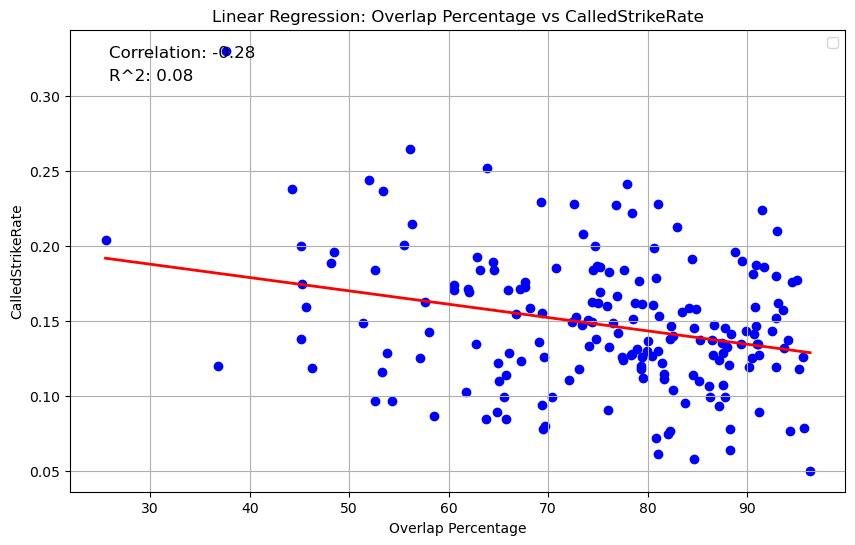

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_sl_stats_w_overlap[['overlap_percentage']]
y = full_league_sl_stats_w_overlap['CalledStrikeRate']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_sl_stats_w_overlap['predicted_CalledStrikeRate'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['CalledStrikeRate'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['CalledStrikeRate'], color='blue')
plt.plot(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['predicted_CalledStrikeRate'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('CalledStrikeRate')
plt.title('Linear Regression: Overlap Percentage vs CalledStrikeRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


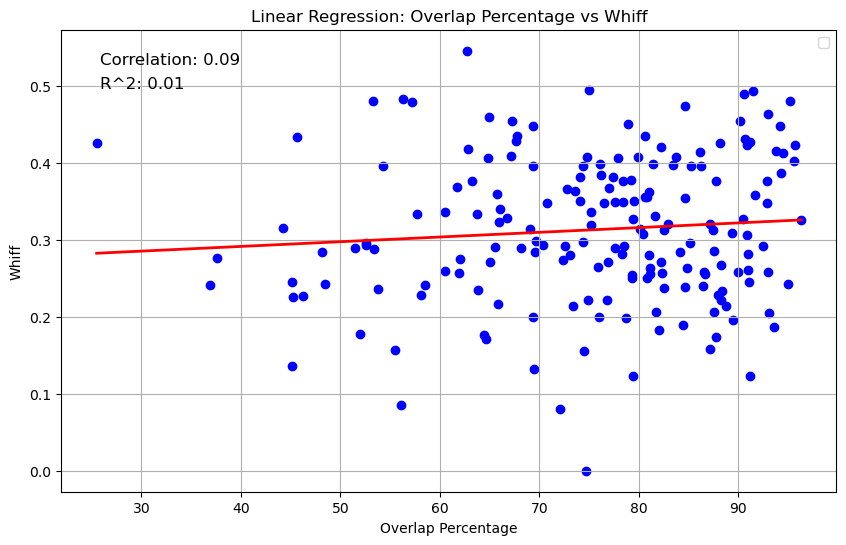

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_sl_stats_w_overlap[['overlap_percentage']]
y = full_league_sl_stats_w_overlap['Whiff']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_sl_stats_w_overlap['predicted_Whiff'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['Whiff'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['Whiff'], color='blue')
plt.plot(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['predicted_Whiff'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('Whiff')
plt.title('Linear Regression: Overlap Percentage vs Whiff')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


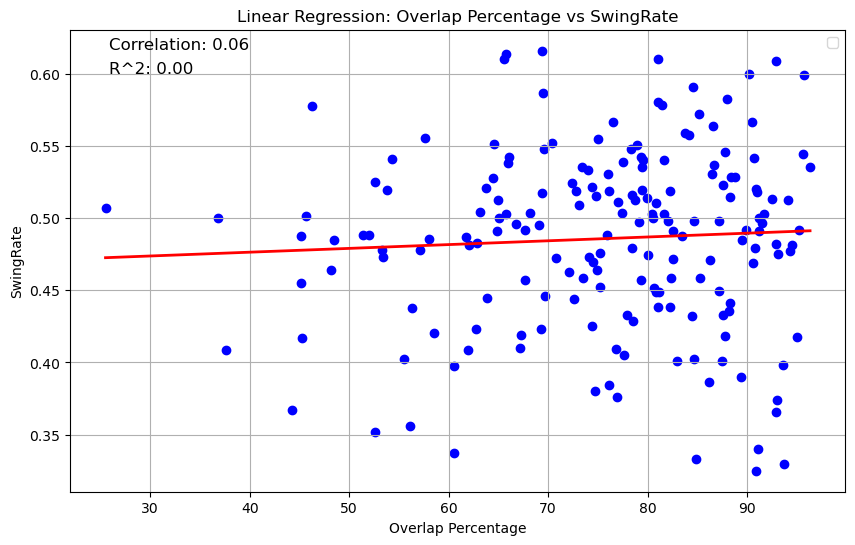

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_sl_stats_w_overlap[['overlap_percentage']]
y = full_league_sl_stats_w_overlap['SwingRate']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_sl_stats_w_overlap['predicted_SwingRate'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['SwingRate'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['SwingRate'], color='blue')
plt.plot(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['predicted_SwingRate'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('SwingRate')
plt.title('Linear Regression: Overlap Percentage vs SwingRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


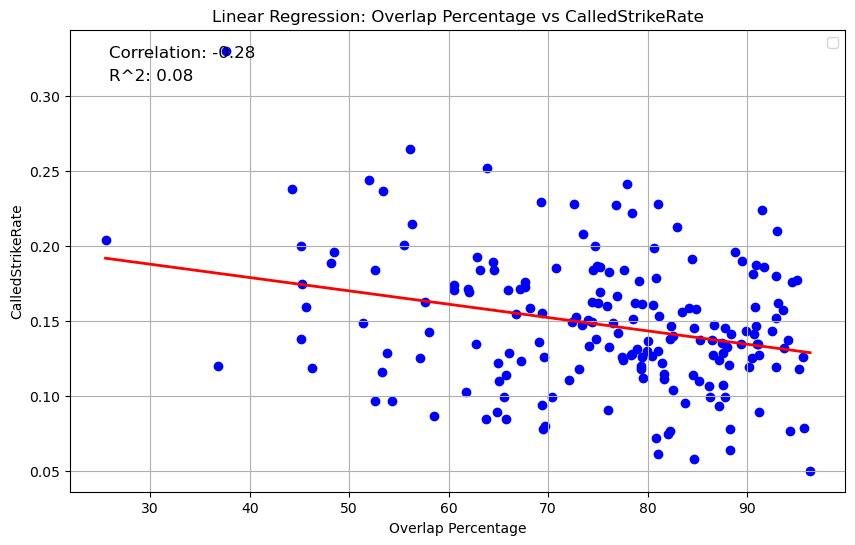

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_sl_stats_w_overlap[['overlap_percentage']]
y = full_league_sl_stats_w_overlap['CalledStrikeRate']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_sl_stats_w_overlap['predicted_CalledStrikeRate'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['CalledStrikeRate'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['CalledStrikeRate'], color='blue')
plt.plot(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['predicted_CalledStrikeRate'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('CalledStrikeRate')
plt.title('Linear Regression: Overlap Percentage vs CalledStrikeRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


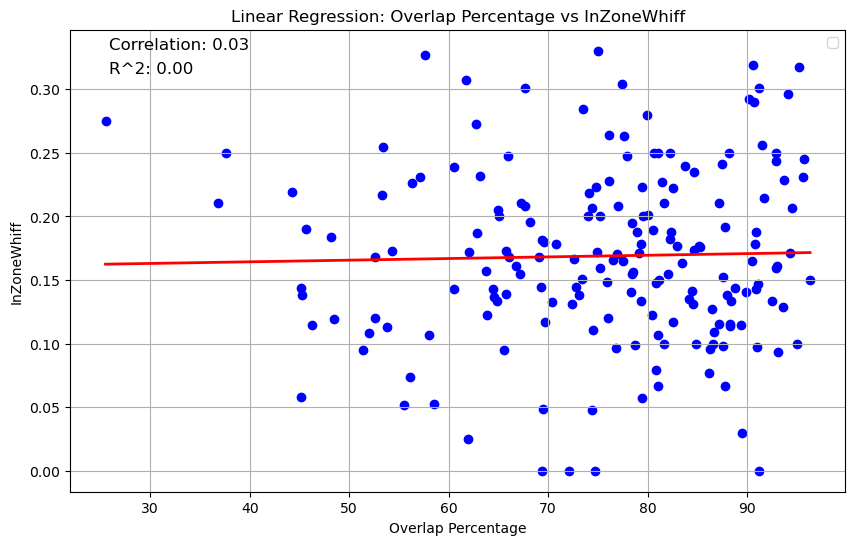

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_sl_stats_w_overlap[['overlap_percentage']]
y = full_league_sl_stats_w_overlap['InZoneWhiff']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_sl_stats_w_overlap['predicted_InZoneWhiff'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['InZoneWhiff'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['InZoneWhiff'], color='blue')
plt.plot(full_league_sl_stats_w_overlap['overlap_percentage'], full_league_sl_stats_w_overlap['predicted_InZoneWhiff'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('InZoneWhiff')
plt.title('Linear Regression: Overlap Percentage vs InZoneWhiff')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.show()


In [18]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_cb = """
SELECT 
    pe.[PitcherId],
	pl.NamePlayer,
    pe.[PitHand],
     p.[x0]
      ,p.[y0]
      ,p.[z0]
      ,p.[vx0]
      ,p.[vy0]
      ,p.[vz0]
      ,p.[ax]
      ,p.[ay]
      ,p.[az],
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px
FROM 
    [mlb_stats].[dbo].[pbp_play_event] pe
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_play_event_pitch] p 
    ON p.[GamePk] = pe.[GamePk] 
    AND p.[PlayId] = pe.[PlayId] 
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_game] g
    ON g.[GamePk] = pe.[GamePk]
LEFT JOIN 
    [mlb_stats].[dbo].[mlb_roster_status] pl
    ON pl.[PlayerID] = pe.[PitcherId] 
WHERE 
    pe.[IsPitch] = 1  
    AND p.PitchType = 'CU' 
    AND YEAR(g.GameDate) = 2024
    AND g.LeagueLevel = 1
	AND g.GameType = 'R'
"""

curveballs=pd.read_sql(query_cb,cnxn) 


filtered_cb = curveballs.loc[:, [
    'PitcherId',
    'NamePlayer',
    'PitHand',
    'x0',
    'y0',
    'z0',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'PitchType',
    'StartSpeed',
    'SpinRate',
    'Extension',
    'ReleaseX',
    'ReleaseZ',
    'ReleaseAngle',
    'ReleaseDirection',
    'pz',
    'px'
]]
filtered_cb['VRA'] = filtered_cb.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
filtered_cb['HRA'] = filtered_cb.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)
pitch_count = filtered_cb['NamePlayer'].value_counts()

filtered_cb_filtered = filtered_cb[filtered_cb['NamePlayer'].isin(pitch_count.index[pitch_count >= 100])]
grouped_cb = filtered_cb_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
   # 'NamePlayer': 'first',  
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
 #   'type': lambda x: (x == 'S').sum() / len(x)   Calculate strike rate for each pitcher
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_cb['VRA_percentile'] = 1 - grouped_cb['VRA'].rank(pct=True)
grouped_cb['HRA_percentile'] = 1 - grouped_cb['HRA'].rank(pct=True)
grouped_cb['release_pos_z_percentile'] = 1 - grouped_cb['ReleaseZ'].rank(pct=True)
grouped_cb['release_pos_x_percentile'] = 1 - grouped_cb['ReleaseX'].rank(pct=True)

grouped_cb['kirby_index'] = (
    grouped_cb['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_cb['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_cb['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_cb['release_pos_x_percentile'] * weights['ReleaseX']
)

ranked_pitchers_weighted_cb = grouped_cb.sort_values('kirby_index', ascending=False)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\3623605539.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  curveballs=pd.read_sql(query_cb,cnxn)


In [19]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complcb = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2024 AND PitchType = 'CU' AND SplitType = 'All' AND Level = 'MLB'
"""

CB_Command=pd.read_sql(query_complcb,cnxn) 

print(CB_Command)

                         Name  PlayerID Throws Level  LeagueLevel  Season  \
0           Verlander, Justin    434378      R   MLB            1    2024   
1               Chavez, Jesse    445926      R   MLB            1    2024   
2             Morton, Charlie    450203      R   MLB            1    2024   
3               Scherzer, Max    453286      R   MLB            1    2024   
4              Wilson, Justin    458677      L   MLB            1    2024   
5                 Lynn, Lance    458681      R   MLB            1    2024   
6            Carrasco, Carlos    471911      R   MLB            1    2024   
7            Kershaw, Clayton    477132      L   MLB            1    2024   
8                 Miley, Wade    489119      L   MLB            1    2024   
9              Quintana, Jose    500779      L   MLB            1    2024   
10               Gibson, Kyle    502043      R   MLB            1    2024   
11           Robertson, David    502085      R   MLB            1    2024   

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\1439461026.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  CB_Command=pd.read_sql(query_complcb,cnxn)


In [20]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde


# Ensure no missing values in the HRA columns of both datasets
filtered_ff_filtered_VRA = filtered_ff_filtered.dropna(subset=['VRA'])
filtered_cb_filtered_VRA = filtered_cb_filtered.dropna(subset=['VRA'])

# Function to calculate the percentage overlap between two distributions
def calculate_overlap(hra_ff, hra_sl):
    kde_ff = gaussian_kde(hra_ff, bw_method='scott')
    kde_sl = gaussian_kde(hra_sl, bw_method='scott')

    x_min = min(hra_ff.min(), hra_sl.min())
    x_max = max(hra_ff.max(), hra_sl.max())
    x_values = np.linspace(x_min, x_max, 1000)

    pdf_ff = kde_ff(x_values)
    pdf_sl = kde_sl(x_values)

    overlap = np.minimum(pdf_ff, pdf_sl)
    overlap_area = np.trapz(overlap, x_values)

    total_area_ff = np.trapz(pdf_ff, x_values)
    total_area_sl = np.trapz(pdf_sl, x_values)
    percentage_overlap = (overlap_area / min(total_area_ff, total_area_sl)) * 100

    return percentage_overlap

# Get unique players
unique_pitchers = set(filtered_ff_filtered_VRA['NamePlayer']).intersection(filtered_cb_filtered_VRA['NamePlayer'])

# Calculate overlap for each player
overlap_results = []

for player in unique_pitchers:
    player_ff = filtered_ff_filtered_VRA[filtered_ff_filtered_VRA['NamePlayer'] == player]
    player_cb = filtered_cb_filtered_VRA[filtered_cb_filtered_VRA['NamePlayer'] == player]
    
    if len(player_ff) > 0 and len(player_cb) > 0:
        overlap_percentage = calculate_overlap(player_ff['VRA'], player_cb['VRA'])
        overlap_results.append({
            'NamePlayer': player,
            'PitcherId': player_ff.iloc[0]['PitcherId'],
            'overlap_percentage': overlap_percentage
        })

# Create a DataFrame with the results
cb_overlap_df = pd.DataFrame(overlap_results)

# Order the results from highest to lowest overlap percentage
cb_league_overlap_df_sorted = cb_overlap_df.sort_values(by='overlap_percentage', ascending=False)

# Display the sorted results
print(cb_league_overlap_df_sorted)


                  NamePlayer  PitcherId  overlap_percentage
78              James Paxton     572020           63.577214
62            Eduard Bazardo     660825           62.583488
116            Kyle Freeland     607536           56.761987
7                Pablo López     641154           54.557379
21         Jordan Montgomery     656756           54.261312
83             Trevor Megill     656730           53.976872
4            Carlos Carrasco     471911           52.863208
79               Jhoan Duran     661395           52.275523
65                Lance Lynn     458681           51.181048
84             Louie Varland     686973           50.728857
75                 José Ruiz     614179           50.656885
59             Craig Kimbrel     518886           49.905519
115            Jose Quintana     500779           48.771787
56              Zack Wheeler     554430           48.018257
8                  Ben Brown     676962           47.573759
102            Logan Gilbert     669302 

In [21]:
selected_cb_stats= CB_Command.loc[:, ['PlayerID', 'StrikeRate', 'CalledStrikeRate', 'Whiff', 'InZone', 'SwingRate', 'OutZoneSwing','InZoneWhiff', 'StuffPlus']]
full_league_cb_stats_w_overlap = pd.merge(cb_league_overlap_df_sorted, selected_cb_stats, how='left', left_on='PitcherId', right_on='PlayerID')
display(full_league_cb_stats_w_overlap)

,NamePlayer,PitcherId,overlap_percentage,PlayerID,StrikeRate,CalledStrikeRate,Whiff,InZone,SwingRate,OutZoneSwing,InZoneWhiff,StuffPlus
0,James Paxton,572020,63.577214,572020,0.587209,0.160853,0.363636,0.356589,0.426357,0.322289,0.150442,35.0
1,Eduard Bazardo,660825,62.583488,660825,0.625954,0.160305,0.327869,0.358779,0.465649,0.392857,0.107143,50.0
2,Kyle Freeland,607536,56.761987,607536,0.594470,0.087558,0.490909,0.230415,0.506912,0.437126,0.270270,25.0
3,Pablo López,641154,54.557379,641154,0.542601,0.098655,0.343434,0.286996,0.443946,0.333333,0.108696,50.0
4,Jordan Montgomery,656756,54.261312,656756,0.574074,0.152778,0.335165,0.293981,0.421296,0.367213,0.128571,35.0
5,Trevor Megill,656730,53.976872,656730,0.572414,0.144828,0.629032,0.282759,0.427586,0.384615,0.227273,75.0
6,Carlos Carrasco,471911,52.863208,471911,0.470085,0.085470,0.222222,0.222222,0.384615,0.296703,0.166667,40.0
7,Jhoan Duran,661395,52.275523,661395,0.540230,0.160920,0.378788,0.385057,0.379310,0.252336,0.153846,60.0
8,Lance Lynn,458681,51.181048,458681,0.568966,0.103448,0.203704,0.275862,0.465517,0.345238,0.040000,35.0
9,Louie Varland,686973,50.728857,686973,0.630769,0.130769,0.307692,0.430769,0.500000,0.310811,0.166667,50.0


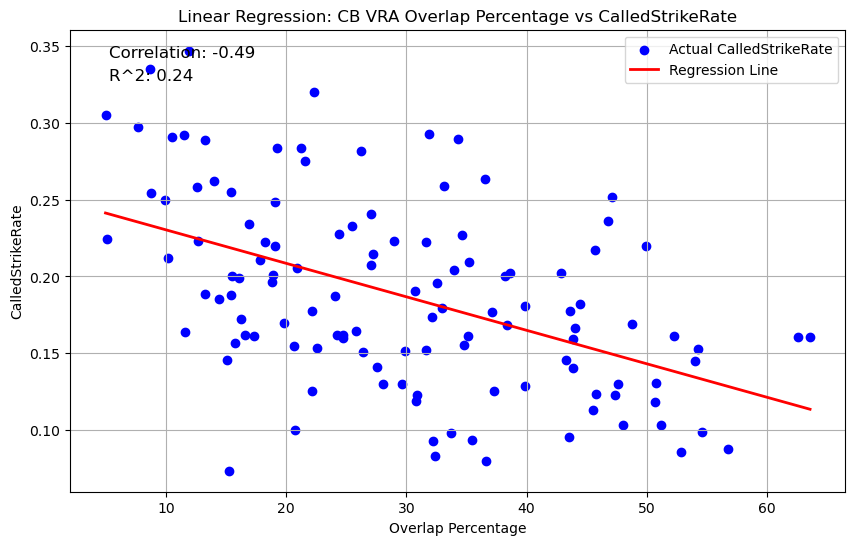

In [39]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_cb_stats_w_overlap[['overlap_percentage']]
y = full_league_cb_stats_w_overlap['CalledStrikeRate']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_cb_stats_w_overlap['predicted_CalledStrikeRate'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['CalledStrikeRate'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['CalledStrikeRate'], color='blue', label='Actual CalledStrikeRate')
plt.plot(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['predicted_CalledStrikeRate'], color='red', linewidth=2, label='Regression Line')
plt.xlabel('Overlap Percentage')
plt.ylabel('CalledStrikeRate')
plt.title('Linear Regression: CB VRA Overlap Percentage vs CalledStrikeRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


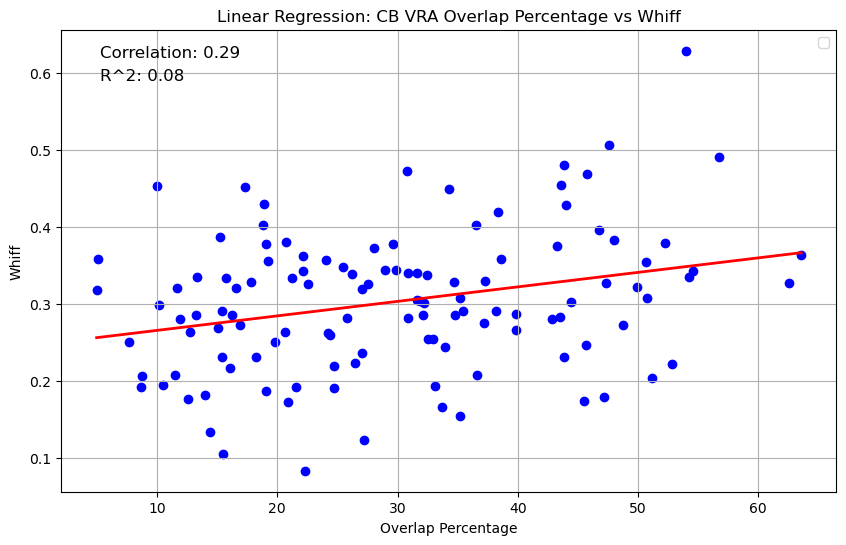

In [48]:

import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_cb_stats_w_overlap[['overlap_percentage']]
y = full_league_cb_stats_w_overlap['Whiff']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_cb_stats_w_overlap['predicted_CalledStrikeRate'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['Whiff'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['Whiff'], color='blue')
plt.plot(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['predicted_CalledStrikeRate'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('Whiff')
plt.title('Linear Regression: CB VRA Overlap Percentage vs Whiff')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


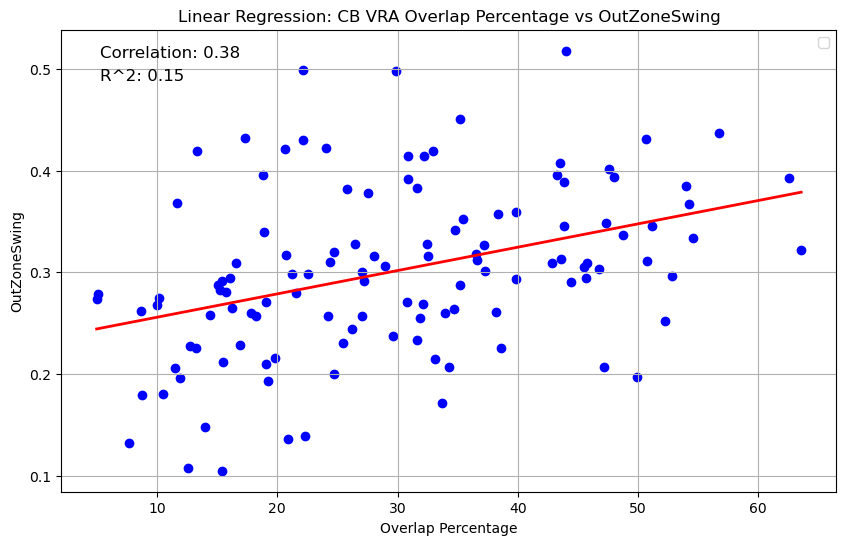

In [49]:

import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_cb_stats_w_overlap[['overlap_percentage']]
y = full_league_cb_stats_w_overlap['OutZoneSwing']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_cb_stats_w_overlap['predicted_OutZoneSwing'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['OutZoneSwing'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['OutZoneSwing'], color='blue')
plt.plot(full_league_cb_stats_w_overlap['overlap_percentage'], full_league_cb_stats_w_overlap['predicted_OutZoneSwing'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('OutZoneSwing')
plt.title('Linear Regression: CB VRA Overlap Percentage vs OutZoneSwing')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


In [25]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_ch = """
SELECT 
    pe.[PitcherId],
	pl.NamePlayer,
    pe.[PitHand],
     p.[x0]
      ,p.[y0]
      ,p.[z0]
      ,p.[vx0]
      ,p.[vy0]
      ,p.[vz0]
      ,p.[ax]
      ,p.[ay]
      ,p.[az],
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px
FROM 
    [mlb_stats].[dbo].[pbp_play_event] pe
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_play_event_pitch] p 
    ON p.[GamePk] = pe.[GamePk] 
    AND p.[PlayId] = pe.[PlayId] 
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_game] g
    ON g.[GamePk] = pe.[GamePk]
LEFT JOIN 
    [mlb_stats].[dbo].[mlb_roster_status] pl
    ON pl.[PlayerID] = pe.[PitcherId] 
WHERE 
    pe.[IsPitch] = 1  
    AND p.PitchType = 'CH' 
    AND YEAR(g.GameDate) = 2024
    AND g.LeagueLevel = 1
	AND g.GameType = 'R'
"""

Changeups=pd.read_sql(query_ch,cnxn) 


filtered_ch = Changeups.loc[:, [
    'PitcherId',
    'NamePlayer',
    'PitHand',
    'x0',
    'y0',
    'z0',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'PitchType',
    'StartSpeed',
    'SpinRate',
    'Extension',
    'ReleaseX',
    'ReleaseZ',
    'ReleaseAngle',
    'ReleaseDirection',
    'pz',
    'px'
]]
filtered_ch['VRA'] = filtered_ch.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
filtered_ch['HRA'] = filtered_ch.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)
pitch_count = filtered_ch['NamePlayer'].value_counts()

filtered_ch_filtered = filtered_ch[filtered_ch['NamePlayer'].isin(pitch_count.index[pitch_count >= 100])]
grouped_ch = filtered_ch_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
   # 'NamePlayer': 'first',  
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
 #   'type': lambda x: (x == 'S').sum() / len(x)   Calculate strike rate for each pitcher
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_ch['VRA_percentile'] = 1 - grouped_ch['VRA'].rank(pct=True)
grouped_ch['HRA_percentile'] = 1 - grouped_ch['HRA'].rank(pct=True)
grouped_ch['release_pos_z_percentile'] = 1 - grouped_ch['ReleaseZ'].rank(pct=True)
grouped_ch['release_pos_x_percentile'] = 1 - grouped_ch['ReleaseX'].rank(pct=True)

grouped_ch['kirby_index'] = (
    grouped_ch['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_ch['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_ch['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_ch['release_pos_x_percentile'] * weights['ReleaseX']
)

ranked_pitchers_weighted_ch = grouped_ch.sort_values('kirby_index', ascending=False)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\310439622.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Changeups=pd.read_sql(query_ch,cnxn)


In [26]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complch = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2024 AND PitchType = 'CH' AND SplitType = 'All' AND Level = 'MLB'
"""

Ch_Command=pd.read_sql(query_complch,cnxn) 

print(Ch_Command)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_22256\980443571.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Ch_Command=pd.read_sql(query_complch,cnxn)


                         Name  PlayerID Throws Level  LeagueLevel  Season  \
0           Verlander, Justin    434378      R   MLB            1    2024   
1               Chavez, Jesse    445926      R   MLB            1    2024   
2             Morton, Charlie    450203      R   MLB            1    2024   
3               Scherzer, Max    453286      R   MLB            1    2024   
4              Wilson, Justin    458677      L   MLB            1    2024   
5                 Lynn, Lance    458681      R   MLB            1    2024   
6            Carrasco, Carlos    471911      R   MLB            1    2024   
7                 Miley, Wade    489119      L   MLB            1    2024   
8              Ottavino, Adam    493603      R   MLB            1    2024   
9              Quintana, Jose    500779      L   MLB            1    2024   
10               Gibson, Kyle    502043      R   MLB            1    2024   
11           Robertson, David    502085      R   MLB            1    2024   

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde


# Ensure no missing values in the HRA columns of both datasets
filtered_ff_filtered_HRA = filtered_ff_filtered.dropna(subset=['HRA'])
filtered_ch_filtered_HRA = filtered_ch_filtered.dropna(subset=['HRA'])

# Function to calculate the percentage overlap between two distributions
def calculate_overlap(hra_ff, hra_sl):
    kde_ff = gaussian_kde(hra_ff, bw_method='scott')
    kde_sl = gaussian_kde(hra_sl, bw_method='scott')

    x_min = min(hra_ff.min(), hra_sl.min())
    x_max = max(hra_ff.max(), hra_sl.max())
    x_values = np.linspace(x_min, x_max, 1000)

    pdf_ff = kde_ff(x_values)
    pdf_sl = kde_sl(x_values)

    overlap = np.minimum(pdf_ff, pdf_sl)
    overlap_area = np.trapz(overlap, x_values)

    total_area_ff = np.trapz(pdf_ff, x_values)
    total_area_sl = np.trapz(pdf_sl, x_values)
    percentage_overlap = (overlap_area / min(total_area_ff, total_area_sl)) * 100

    return percentage_overlap

# Get unique players
unique_pitchers = set(filtered_ff_filtered_HRA['NamePlayer']).intersection(filtered_ch_filtered_HRA['NamePlayer'])

# Calculate overlap for each player
overlap_results = []

for player in unique_pitchers:
    player_ff = filtered_ff_filtered_HRA[filtered_ff_filtered_HRA['NamePlayer'] == player]
    player_ch = filtered_ch_filtered_HRA[filtered_ch_filtered_HRA['NamePlayer'] == player]
    
    if len(player_ff) > 0 and len(player_ch) > 0:
        overlap_percentage = calculate_overlap(player_ff['HRA'], player_ch['HRA'])
        overlap_results.append({
            'NamePlayer': player,
            'PitcherId': player_ff.iloc[0]['PitcherId'],
            'overlap_percentage': overlap_percentage
        })

# Create a DataFrame with the results
ch_overlap_df = pd.DataFrame(overlap_results)

# Order the results from highest to lowest overlap percentage
ch_league_overlap_df_sorted = ch_overlap_df.sort_values(by='overlap_percentage', ascending=False)

# Display the sorted results
print(ch_league_overlap_df_sorted)


                  NamePlayer  PitcherId  overlap_percentage
8            Carlos Carrasco     471911           97.399119
128                 Jon Gray     592351           96.945139
0                Jhony Brito     666745           96.132503
46                Jacob Latz     656641           95.356149
11                   DJ Herz     687792           95.170892
142            Jose Quintana     500779           94.889783
2           Michael Lorenzen     547179           94.729040
148                 JP Sears     676664           94.571220
86               Cole Ragans     666142           94.440116
49             Luis Castillo     622491           94.347794
19              Jorge Alcala     660896           94.301182
27            Reynaldo López     625643           93.776816
140         Patrick Sandoval     663776           93.745620
100               José Buttó     676130           93.743932
109            Trevor Rogers     669432           93.720179
104              José Suarez     660761 

In [28]:
selected_ch_stats = Ch_Command.loc[:, ['PlayerID', 'StrikeRate', 'CalledStrikeRate', 'Whiff', 'InZone', 'SwingRate', 'OutZoneSwing','InZoneWhiff', 'StuffPlus']]
full_league_ch_stats_w_overlap = pd.merge(ch_league_overlap_df_sorted, selected_ch_stats, how='left', left_on='PitcherId', right_on='PlayerID')
display(full_league_ch_stats_w_overlap)

,NamePlayer,PitcherId,overlap_percentage,PlayerID,StrikeRate,CalledStrikeRate,Whiff,InZone,SwingRate,OutZoneSwing,InZoneWhiff,StuffPlus
0,Carlos Carrasco,471911,97.399119,471911,0.604113,0.095116,0.287879,0.326478,0.508997,0.385496,0.082474,40.0
1,Jon Gray,592351,96.945139,592351,0.650000,0.100000,0.218182,0.490000,0.550000,0.372549,0.111111,35.0
2,Jhony Brito,666745,96.132503,666745,0.712963,0.157407,0.266667,0.564815,0.555556,0.244681,0.268041,50.0
3,Jacob Latz,656641,95.356149,656641,0.673913,0.086957,0.388889,0.347826,0.586957,0.458333,0.207547,60.0
4,DJ Herz,687792,95.170892,687792,0.630435,0.143478,0.258929,0.391304,0.486957,0.378571,0.169492,50.0
5,Jose Quintana,500779,94.889783,500779,0.467290,0.079439,0.343373,0.177570,0.387850,0.309659,0.087719,40.0
6,Michael Lorenzen,547179,94.729040,547179,0.562162,0.043243,0.364583,0.305405,0.518919,0.346304,0.281553,50.0
7,JP Sears,676664,94.571220,676664,0.613990,0.137306,0.217391,0.406736,0.476684,0.292576,0.136752,35.0
8,Cole Ragans,666142,94.440116,666142,0.650582,0.078203,0.488372,0.377704,0.572379,0.422460,0.413978,65.0
9,Luis Castillo,622491,94.347794,622491,0.611570,0.066116,0.242424,0.272727,0.545455,0.435606,0.132530,50.0


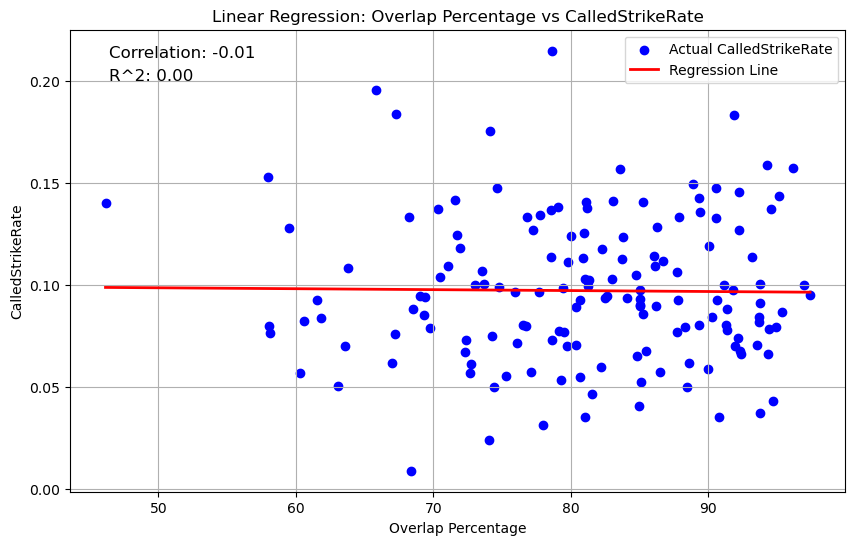

In [29]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_ch_stats_w_overlap[['overlap_percentage']]
y = full_league_ch_stats_w_overlap['CalledStrikeRate']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_ch_stats_w_overlap['predicted_CalledStrikeRate'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['CalledStrikeRate'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['CalledStrikeRate'], color='blue', label='Actual CalledStrikeRate')
plt.plot(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['predicted_CalledStrikeRate'], color='red', linewidth=2, label='Regression Line')
plt.xlabel('Overlap Percentage')
plt.ylabel('CalledStrikeRate')
plt.title('Linear Regression: Overlap Percentage vs CalledStrikeRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


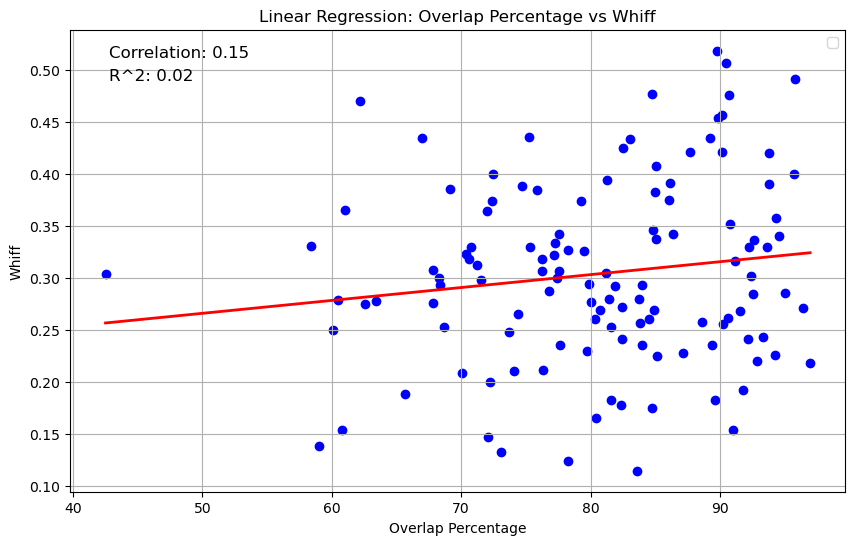

In [61]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_ch_stats_w_overlap[['overlap_percentage']]
y = full_league_ch_stats_w_overlap['Whiff']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_ch_stats_w_overlap['predicted_Whiff'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['Whiff'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['Whiff'], color='blue')
plt.plot(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['predicted_Whiff'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('Whiff')
plt.title('Linear Regression: Overlap Percentage vs Whiff')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


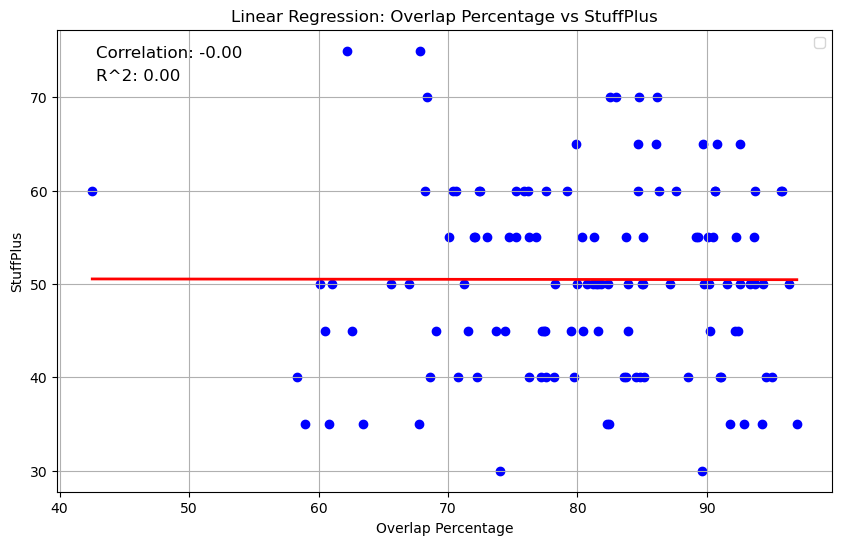

In [62]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_ch_stats_w_overlap[['overlap_percentage']]
y = full_league_ch_stats_w_overlap['StuffPlus']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_ch_stats_w_overlap['predicted_StuffPlus'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['StuffPlus'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['StuffPlus'], color='blue')
plt.plot(full_league_ch_stats_w_overlap['overlap_percentage'], full_league_ch_stats_w_overlap['predicted_StuffPlus'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('StuffPlus')
plt.title('Linear Regression: Overlap Percentage vs StuffPlus')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


In [34]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde


# Ensure no missing values in the HRA columns of both datasets
filtered_ff_filtered_HRA = filtered_ff_filtered.dropna(subset=['HRA'])
filtered_sw_filtered_HRA = filtered_sw_filtered.dropna(subset=['HRA'])

# Function to calculate the percentage overlap between two distributions
def calculate_overlap(hra_ff, hra_sl):
    kde_ff = gaussian_kde(hra_ff, bw_method='scott')
    kde_sl = gaussian_kde(hra_sl, bw_method='scott')

    x_min = min(hra_ff.min(), hra_sl.min())
    x_max = max(hra_ff.max(), hra_sl.max())
    x_values = np.linspace(x_min, x_max, 1000)

    pdf_ff = kde_ff(x_values)
    pdf_sl = kde_sl(x_values)

    overlap = np.minimum(pdf_ff, pdf_sl)
    overlap_area = np.trapz(overlap, x_values)

    total_area_ff = np.trapz(pdf_ff, x_values)
    total_area_sl = np.trapz(pdf_sl, x_values)
    percentage_overlap = (overlap_area / min(total_area_ff, total_area_sl)) * 100

    return percentage_overlap

# Get unique players
unique_pitchers = set(filtered_ff_filtered_HRA['NamePlayer']).intersection(filtered_sw_filtered_HRA['NamePlayer'])

# Calculate overlap for each player
overlap_results = []

for player in unique_pitchers:
    player_ff = filtered_ff_filtered_HRA[filtered_ff_filtered_HRA['NamePlayer'] == player]
    player_sw = filtered_sw_filtered_HRA[filtered_sw_filtered_HRA['NamePlayer'] == player]
    
    if len(player_ff) > 0 and len(player_sw) > 0:
        overlap_percentage = calculate_overlap(player_ff['HRA'], player_sw['HRA'])
        overlap_results.append({
            'NamePlayer': player,
            'PitcherId': player_ff.iloc[0]['PitcherId'],
            'overlap_percentage': overlap_percentage
        })

# Create a DataFrame with the results
sw_overlap_df = pd.DataFrame(overlap_results)

# Order the results from highest to lowest overlap percentage
sw_league_overlap_df_sorted = sw_overlap_df.sort_values(by='overlap_percentage', ascending=False)

# Display the sorted results
print(sw_league_overlap_df_sorted)


               NamePlayer  PitcherId  overlap_percentage
34           Chris Flexen     623167           91.093280
60        Mitchell Parker     680730           90.625576
67           Brady Singer     663903           89.054068
58      Carmen Mlodzinski     669387           86.226671
73             Matt Sauer     669422           85.785371
18           Tanner Bibee     676440           80.893188
36           Tanner Banks     621383           80.403634
8            Matt Manning     666159           79.197784
50         Freddy Peralta     642547           79.140989
80           Nick Pivetta     601713           73.338512
85         Brandon Pfaadt     694297           72.089075
94        Valente Bellozo     678368           70.874202
88          Justin Slaten     686580           70.287912
25              Seth Lugo     607625           69.687346
32     Spencer Arrighetti     681293           68.450739
38            Kyle Gibson     502043           68.303329
0            Zack Littell     6

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde


# Ensure no missing values in the HRA columns of both datasets
filtered_ff_filtered_HRA = filtered_ff_filtered.dropna(subset=['HRA'])
filtered_sw_filtered_HRA = filtered_sw_filtered.dropna(subset=['HRA'])

# Function to calculate the percentage overlap between two distributions
def calculate_overlap(hra_ff, hra_sl):
    kde_ff = gaussian_kde(hra_ff, bw_method='scott')
    kde_sl = gaussian_kde(hra_sl, bw_method='scott')

    x_min = min(hra_ff.min(), hra_sl.min())
    x_max = max(hra_ff.max(), hra_sl.max())
    x_values = np.linspace(x_min, x_max, 1000)

    pdf_ff = kde_ff(x_values)
    pdf_sl = kde_sl(x_values)

    overlap = np.minimum(pdf_ff, pdf_sl)
    overlap_area = np.trapz(overlap, x_values)

    total_area_ff = np.trapz(pdf_ff, x_values)
    total_area_sl = np.trapz(pdf_sl, x_values)
    percentage_overlap = (overlap_area / min(total_area_ff, total_area_sl)) * 100

    return percentage_overlap

# Get unique players
unique_pitchers = set(filtered_ff_filtered_HRA['NamePlayer']).intersection(filtered_sw_filtered_HRA['NamePlayer'])

# Calculate overlap for each player
overlap_results = []

for player in unique_pitchers:
    player_ff = filtered_ff_filtered_HRA[filtered_ff_filtered_HRA['NamePlayer'] == player]
    player_sw = filtered_sw_filtered_HRA[filtered_sw_filtered_HRA['NamePlayer'] == player]
    
    if len(player_ff) > 0 and len(player_sw) > 0:
        overlap_percentage = calculate_overlap(player_ff['HRA'], player_sw['HRA'])
        overlap_results.append({
            'NamePlayer': player,
            'PitcherId': player_ff.iloc[0]['PitcherId'],
            'overlap_percentage': overlap_percentage
        })

# Create a DataFrame with the results
sw_overlap_df = pd.DataFrame(overlap_results)

# Order the results from highest to lowest overlap percentage
sw_league_overlap_df_sorted = sw_overlap_df.sort_values(by='overlap_percentage', ascending=False)

# Display the sorted results
print(sw_league_overlap_df_sorted)


In [36]:
selected_sw_stats = SW_Command.loc[:, ['PlayerID', 'StrikeRate', 'CalledStrikeRate', 'Whiff', 'InZone', 'SwingRate', 'OutZoneSwing','InZoneWhiff', 'StuffPlus']]
full_league_sw_stats_w_overlap = pd.merge(sw_league_overlap_df_sorted, selected_sw_stats, how='left', left_on='PitcherId', right_on='PlayerID')
display(full_league_sw_stats_w_overlap)

,NamePlayer,PitcherId,overlap_percentage,PlayerID,StrikeRate,CalledStrikeRate,Whiff,InZone,SwingRate,OutZoneSwing,InZoneWhiff,StuffPlus
0,Chris Flexen,623167,91.093280,623167,0.521472,0.085890,0.253521,0.239264,0.435583,0.330645,0.066667,30.0
1,Mitchell Parker,680730,90.625576,680730,0.734940,0.126506,0.326733,0.475904,0.608434,0.482759,0.203390,55.0
2,Brady Singer,663903,89.054068,663903,0.573099,0.029240,0.376344,0.304094,0.543860,0.378151,0.125000,45.0
3,Carmen Mlodzinski,669387,86.226671,669387,0.656000,0.080000,0.319444,0.408000,0.576000,0.391892,0.139535,55.0
4,Matt Sauer,669422,85.785371,669422,0.652174,0.115942,0.270270,0.434783,0.536232,0.333333,0.166667,60.0
5,Tanner Bibee,676440,80.893188,676440,0.659533,0.142023,0.334586,0.494163,0.517510,0.296154,0.264550,55.0
6,Tanner Banks,621383,80.403634,621383,0.616438,0.143836,0.304348,0.431507,0.472603,0.289157,0.222222,55.0
7,Matt Manning,666159,79.197784,666159,0.682432,0.195946,0.277778,0.486486,0.486486,0.342105,0.195652,60.0
8,Freddy Peralta,642547,79.140989,642547,0.581688,0.147217,0.396694,0.371634,0.434470,0.308571,0.231343,65.0
9,Nick Pivetta,601713,73.338512,601713,0.641631,0.094421,0.364706,0.409871,0.547210,0.363636,0.174194,55.0


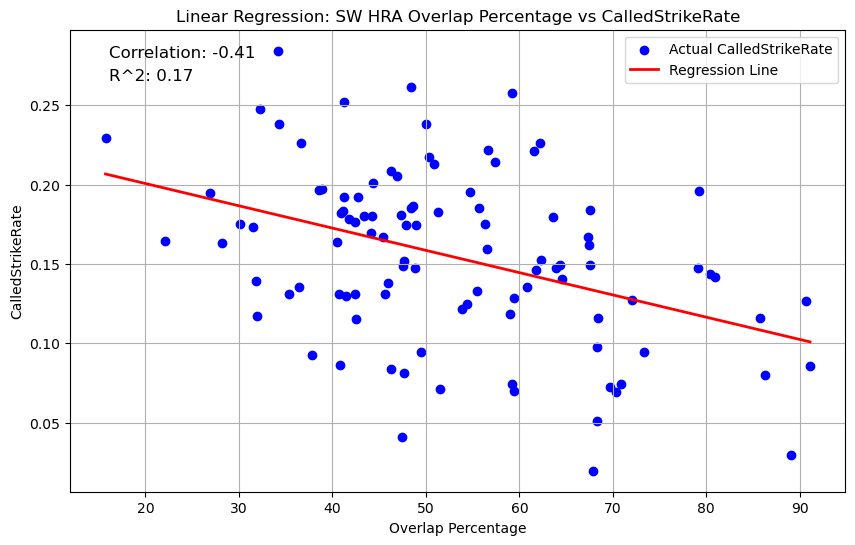

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_sw_stats_w_overlap[['overlap_percentage']]
y = full_league_sw_stats_w_overlap['CalledStrikeRate']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_sw_stats_w_overlap['predicted_CalledStrikeRate'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['CalledStrikeRate'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['CalledStrikeRate'], color='blue', label='Actual CalledStrikeRate')
plt.plot(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['predicted_CalledStrikeRate'], color='red', linewidth=2, label='Regression Line')
plt.xlabel('Overlap Percentage')
plt.ylabel('CalledStrikeRate')
plt.title('Linear Regression: SW HRA Overlap Percentage vs CalledStrikeRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


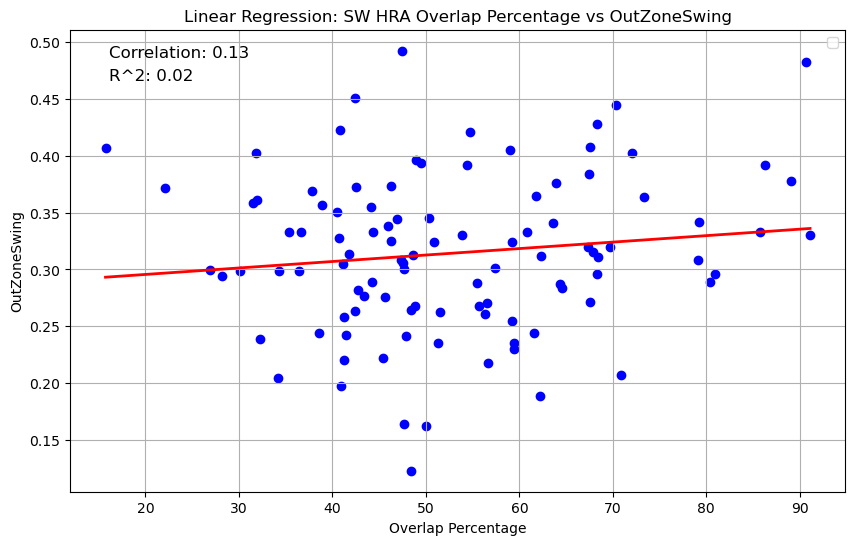

In [42]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_sw_stats_w_overlap[['overlap_percentage']]
y = full_league_sw_stats_w_overlap['OutZoneSwing']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_sw_stats_w_overlap['predicted_OutZoneSwing'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['OutZoneSwing'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['OutZoneSwing'], color='blue')
plt.plot(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['predicted_OutZoneSwing'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('OutZoneSwing')
plt.title('Linear Regression: SW HRA Overlap Percentage vs OutZoneSwing')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


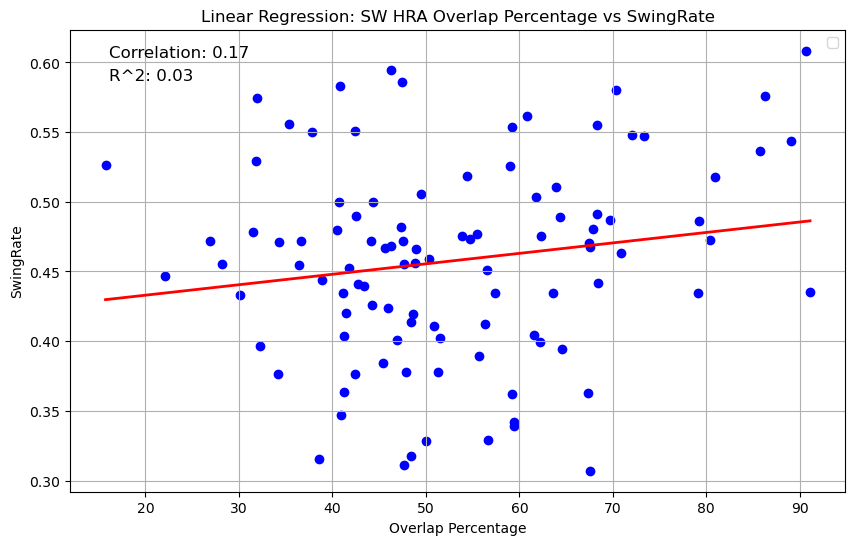

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


X = full_league_sw_stats_w_overlap[['overlap_percentage']]
y = full_league_sw_stats_w_overlap['SwingRate']

model = LinearRegression()
model.fit(X, y)

# Predict values
full_league_sw_stats_w_overlap['predicted_SwingRate'] = model.predict(X)

# Calculate correlation coefficient and R^2 value
correlation, _ = pearsonr(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['SwingRate'])
r_squared = model.score(X, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['SwingRate'], color='blue')
plt.plot(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['predicted_SwingRate'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('SwingRate')
plt.title('Linear Regression: SW HRA Overlap Percentage vs SwingRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


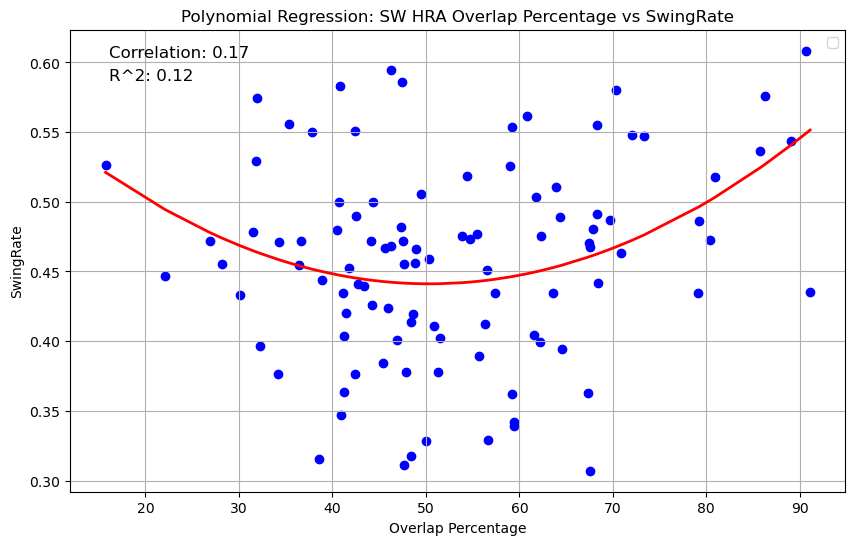

In [46]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Create polynomial features (degree 2 for a parabola)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(full_league_sw_stats_w_overlap[['overlap_percentage']])

# Fit the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_poly, y)

# Predict values using the polynomial model
full_league_sw_stats_w_overlap['predicted_SwingRate_poly'] = model_poly.predict(X_poly)

# Calculate correlation coefficient and R^2 value for the polynomial fit
correlation_poly, _ = pearsonr(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['SwingRate'])
r_squared_poly = model_poly.score(X_poly, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['SwingRate'], color='blue')
plt.plot(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['predicted_SwingRate_poly'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('SwingRate')
plt.title('Polynomial Regression: SW HRA Overlap Percentage vs SwingRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation_poly:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared_poly:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Create polynomial features (degree 2 for a parabola)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(full_league_sw_stats_w_overlap[['overlap_percentage']])

# Fit the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_poly, y)

# Predict values using the polynomial model
full_league_sw_stats_w_overlap['predicted_SwingRate_poly'] = model_poly.predict(X_poly)

# Calculate correlation coefficient and R^2 value for the polynomial fit
correlation_poly, _ = pearsonr(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['SwingRate'])
r_squared_poly = model_poly.score(X_poly, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['SwingRate'], color='blue')
plt.plot(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['predicted_SwingRate_poly'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('SwingRate')
plt.title('Polynomial Regression: SW HRA Overlap Percentage vs SwingRate')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation_poly:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared_poly:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


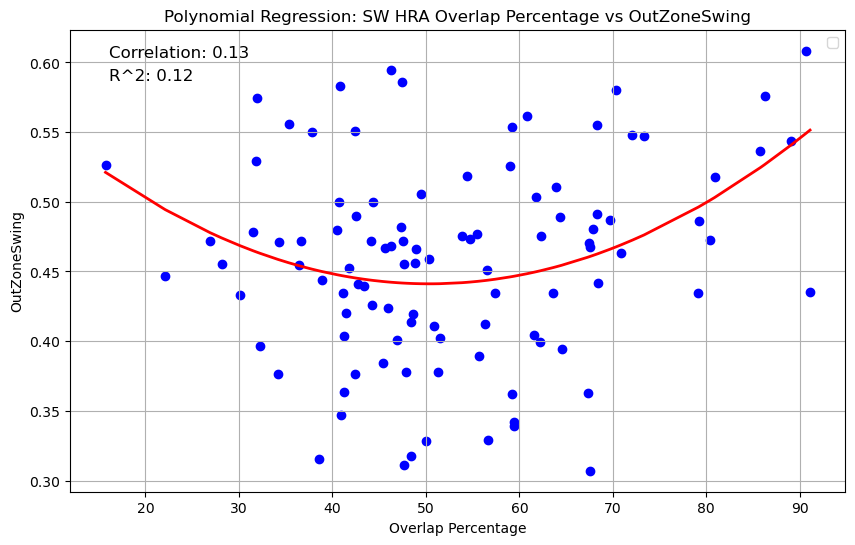

In [47]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Create polynomial features (degree 2 for a parabola)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(full_league_sw_stats_w_overlap[['overlap_percentage']])

# Fit the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_poly, y)

# Predict values using the polynomial model
full_league_sw_stats_w_overlap['predicted_OutZoneSwing_poly'] = model_poly.predict(X_poly)

# Calculate correlation coefficient and R^2 value for the polynomial fit
correlation_poly, _ = pearsonr(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['OutZoneSwing'])
r_squared_poly = model_poly.score(X_poly, y)

# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['SwingRate'], color='blue')
plt.plot(full_league_sw_stats_w_overlap['overlap_percentage'], full_league_sw_stats_w_overlap['predicted_OutZoneSwing_poly'], color='red', linewidth=2)
plt.xlabel('Overlap Percentage')
plt.ylabel('OutZoneSwing')
plt.title('Polynomial Regression: SW HRA Overlap Percentage vs OutZoneSwing')
plt.legend()
plt.grid(True)

# Add correlation and R^2 value to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation_poly:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')
plt.text(0.05, 0.90, f'R^2: {r_squared_poly:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')

plt.show()


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


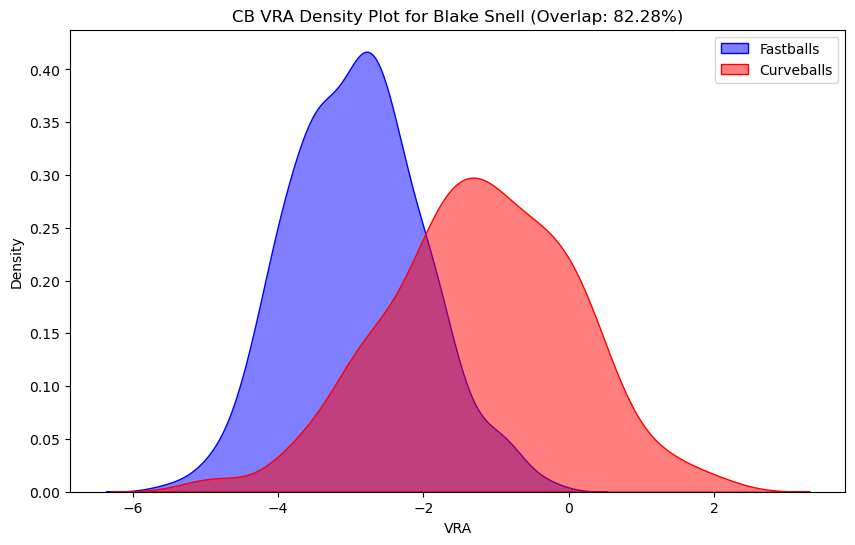

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_for_player(player_name, filtered_ff_filtered_VRA, filtered_cb_filtered_VRA, overlap_df):
    # Filter the data for the selected player
    hra_ff = filtered_ff_filtered_VRA[filtered_ff_filtered_VRA['NamePlayer'] == player_name]['VRA']
    hra_sl = filtered_cb_filtered_VRA[filtered_cb_filtered_VRA['NamePlayer'] == player_name]['VRA']
    
    # Get the overlap percentage for the player
    overlap_percentage = overlap_df[overlap_df['NamePlayer'] == player_name]['overlap_percentage'].values[0]
    
    # Check if there are enough data points
    if len(hra_ff) > 0 and len(hra_sl) > 0:
        # Create a density plot
        plt.figure(figsize=(10, 6))
        sns.kdeplot(hra_ff, label='Fastballs', bw_method='scott', fill=True, color='blue', alpha=0.5)
        sns.kdeplot(hra_sl, label='Curveballs', bw_method='scott', fill=True, color='red', alpha=0.5)
        
        plt.title(f'CB VRA Density Plot for {player_name} (Overlap: {overlap_percentage:.2f}%)')
        plt.xlabel('VRA')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    else:
        print(f'Not enough data points for player {player_name} to create a density plot.')

# Example usage:
# Replace 'YourPlayerName' with the actual name of the player you want to plot
plot_density_for_player('Blake Snell', filtered_ff_filtered_VRA, filtered_cb_filtered_VRA, overlap_df)


In [59]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde


# Ensure no missing values in the HRA columns of both datasets
filtered_si_filtered_HRA = filtered_si_filtered.dropna(subset=['HRA'])
filtered_sw_filtered_HRA = filtered_sw_filtered.dropna(subset=['HRA'])

# Function to calculate the percentage overlap between two distributions
def calculate_overlap(hra_ff, hra_sl):
    kde_ff = gaussian_kde(hra_ff, bw_method='scott')
    kde_sl = gaussian_kde(hra_sl, bw_method='scott')

    x_min = min(hra_ff.min(), hra_sl.min())
    x_max = max(hra_ff.max(), hra_sl.max())
    x_values = np.linspace(x_min, x_max, 1000)

    pdf_ff = kde_ff(x_values)
    pdf_sl = kde_sl(x_values)

    overlap = np.minimum(pdf_ff, pdf_sl)
    overlap_area = np.trapz(overlap, x_values)

    total_area_ff = np.trapz(pdf_ff, x_values)
    total_area_sl = np.trapz(pdf_sl, x_values)
    percentage_overlap = (overlap_area / min(total_area_ff, total_area_sl)) * 100

    return percentage_overlap

# Get unique players
unique_pitchers = set(filtered_si_filtered_HRA['NamePlayer']).intersection(filtered_sw_filtered_HRA['NamePlayer'])

# Calculate overlap for each player
overlap_results = []

for player in unique_pitchers:
    player_si = filtered_si_filtered_HRA[filtered_si_filtered_HRA['NamePlayer'] == player]
    player_sw = filtered_sw_filtered_HRA[filtered_sw_filtered_HRA['NamePlayer'] == player]
    
    if len(player_si) > 0 and len(player_sw) > 0:
        overlap_percentage = calculate_overlap(player_si['HRA'], player_sw['HRA'])
        overlap_results.append({
            'NamePlayer': player,
            'PitcherId': player_ff.iloc[0]['PitcherId'],
            'overlap_percentage': overlap_percentage
        })

# Create a DataFrame with the results
si_sw_overlap_df = pd.DataFrame(overlap_results)

# Order the results from highest to lowest overlap percentage
si_sw_league_overlap_df_sorted = si_sw_overlap_df.sort_values(by='overlap_percentage', ascending=False)

# Display the sorted results
print(si_sw_league_overlap_df_sorted)


               NamePlayer  PitcherId  overlap_percentage
100            Kyle Tyler     571945           81.318336
95        Graham Ashcraft     571945           74.880711
56         Clarke Schmidt     571945           72.983488
89            Erick Fedde     571945           70.932781
74           Brady Singer     571945           67.455621
29         Trent Thornton     571945           66.983871
45            Paul Skenes     571945           60.795906
76             José Buttó     571945           59.900287
3            Osvaldo Bido     571945           59.827385
115         Miles Mikolas     571945           58.201909
91          Anthony Banda     571945           57.330218
2               Jake Bird     571945           55.793283
103       Justin Lawrence     571945           54.558456
59           Zack Wheeler     571945           54.220059
53          Seth Martinez     571945           53.624967
33           Mitch Spence     571945           53.614595
10          Luis Severino     5